# Pure Planet - Analysis of Website Metrics

### Connor Goddard

**6th August 2018**

Source: [Github](https://github.com/cgddrd/pureplanet)

### Brief

Analyse usage metrics across Pure Planet website to derive insight to answer the following:

1. What was each channel’s contribution to app store visits and saved quotes over time?
2. How does quote conversion vary by channel?
3. Which channel is most critical?

In [1]:
import numpy as np
import pandas as pd
import plotly.plotly as py
import utils
import matplotlib.pyplot as plt

utils.init_plotly(username='cgddrd', api_key='F7STNJas2eDGiBpOva9a')

/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


## Data Exploration

In [2]:
df = pd.read_csv('../data/raw/ga.csv', header=0, parse_dates=['date'], date_parser=utils.parse_csv_date, index_col='date')
df.head(5)

category          metric  value
date                                             
2017-12-04  Branded Search       app_store     65
2017-12-04  Branded Search  complete_quote    437
2017-12-04  Branded Search      save_quote    165
2017-12-04  Branded Search     start_quote    491
2017-12-04  Branded Search        visitors    901

In [3]:
count = len(df)
no_of_weeks = len(df.groupby(pd.Grouper(freq='W')))
min_date = df.index.min().strftime('%d %b %Y')
max_date = df.index.max().strftime('%d %b %Y')

print('There are %d records in the dataset, spanning across %d weeks from %s to %s.' % (count, no_of_weeks, min_date, max_date))

There are 390 records in the dataset, spanning across 13 weeks from 04 Dec 2017 to 26 Feb 2018.


In [4]:
categories = df['category'].unique()
metrics = df['metric'].unique()

print('Categories:')
print(*categories, sep = ", ") 
print('\nMetrics:')
print(*metrics, sep = ", ") 

Categories:
Branded Search, Direct Traffic, Generic Search, Organic, Paid search, Referral link

Metrics:
app_store, complete_quote, save_quote, start_quote, visitors


In [5]:
colors = ['rgb(32,155,160)', 
          'rgb(253,93,124)', 
          'rgb(28,119,139)', 
          'rgb(182,231,235)', 
          'rgb(35,154,160)', 
          'rgb(35,154,2)']

## Understanding user flow through quote process

In [6]:
# group dataset by metrics (i.e. each stage of the quote process), sum counts and sort by counts largest to smallest.
data = df.groupby(['metric'])['value'].sum().sort_values(ascending=False)

# remove any data for the 'app_store' metric. We aren't interested in this for the funnel chart.
data = data[~data.index.str.contains("app_store")]

fig_metrics_funnel = utils.plot_funnel_chart(data, colors, 'Metrics Funnel')

In [7]:
py.iplot(fig_metrics_funnel)

### Understanding user flow by channel contribution

In [8]:
# group by metrics and then categories (channels), summing their user counts.
metrics_by_channels = df.groupby(['metric', 'category'])["value"].sum().reset_index()

# re-shape results to use 'metric' as index, and 'categories' as columns.
metrics_by_channels = metrics_by_channels.groupby('metric').apply(
    lambda f: f.groupby('category').apply(
        lambda g: g['value'].values
    ))

# calculate sums of all user counts across each metric and sort data frame by these sums (largest to smallest)
metrics_by_channels['sum'] = df.groupby('metric')['value'].sum()
metrics_by_channels.sort_values('sum', ascending=False, inplace=True)

# extract sums into new structure to reference later. 
totals = metrics_by_channels['sum'].values

# drop the 'sum' column from the data frame.
metrics_by_channels.drop('sum', axis=1, inplace=True)

# remove any data for the 'app_store' metric. We aren't interested in this for the funnel chart.
metrics_by_channels = metrics_by_channels[~metrics_by_channels.index.str.contains("app_store")]

In [9]:
fig = utils.plot_stacked_funnel_chart(metrics_by_channels, totals, colors, 'Metrics by Channel Contribution Funnel')
py.iplot(fig)

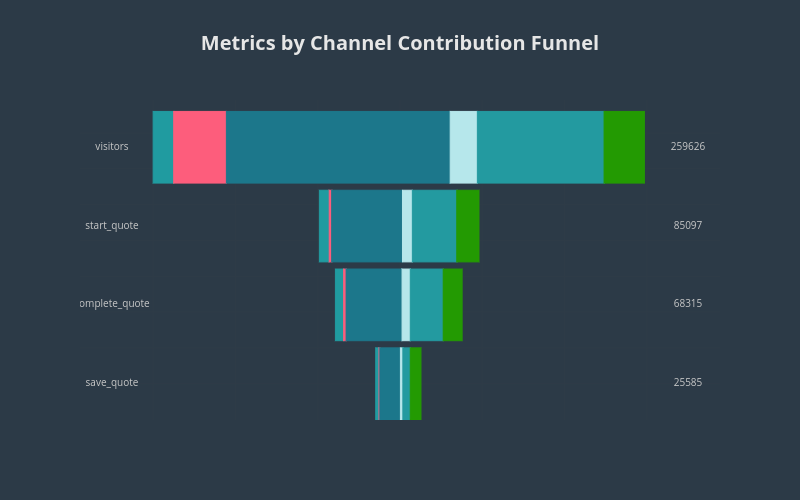

In [10]:
py.image.ishow(fig)

## Quote conversion

In [11]:
df = pd.read_csv('../data/raw/ga.csv', header=0, parse_dates=['date'], date_parser=utils.parse_csv_date, index_col='date')

In [12]:
def calc_conversion_rate(visitors, save_quotes):
    return save_quotes/visitors * 100

### Quote conversion by week

In [13]:
# get weekly totals for 'visitor' and 'save_quote' metrics.
weekly_visitor_totals = df[df['metric'] == 'visitors'].groupby(pd.Grouper(freq='W'))['value'].sum()
weekly_save_quote_totals = df[df['metric'] == 'save_quote'].groupby(pd.Grouper(freq='W'))['value'].sum()

# create data frame to store grouped totals.
metrics = pd.DataFrame(weekly_visitor_totals)
metrics['save_quote'] = weekly_save_quote_totals
metrics.columns = ['visitors', 'save_quote']

# calculate connversion rates for each week.
metrics['conversion_rate'] = calc_conversion_rate(metrics['visitors'], metrics['save_quote'])

metrics.head()

visitors  save_quote  conversion_rate
date                                             
2017-12-10     27384        2101         7.672363
2017-12-17     18917        1693         8.949622
2017-12-24     10009        1020        10.190828
2017-12-31      8717        1042        11.953654
2018-01-07     15611        1850        11.850618

In [14]:
%%capture captured
%matplotlib inline
plt.style.use('ggplot')
import matplotlib.dates as mdates
from matplotlib.dates import MO, TU, WE, TH, FR, SA, SU

fig_conv_by_week, ax1 = plt.subplots(figsize=(10, 8))
ax1.bar(metrics.index, metrics['visitors'], width=2)

ax1.set_ylabel('visitors')
ax1.grid(False)

ax2 = ax1.twinx()

ax2.plot(metrics.index, metrics['conversion_rate'], 'b')

#set ticks every week (Sunday)
ax2.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=SU))

# set minor ticks to every day
ax2.xaxis.set_minor_locator(mdates.DayLocator())

#set major ticks format
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%d %b'))

ax2.set_ylabel('conversion rate', color='b')
ax2.tick_params('y', colors='b')
ax2.set_ylim(bottom = 0, top = (ax2.get_ylim()[1] * 2))

fig_conv_by_week.suptitle('Quote conversion over time')

# use ';' to suppress additional output.
plt.show();

In [15]:
fig_conv_by_week

### Quote conversion by channel

In [16]:
df = pd.read_csv('../data/raw/ga.csv', header=0, parse_dates=['date'], date_parser=utils.parse_csv_date, index_col='date')

In [17]:
# group data by category (channel) and then by metric.
metric_summaries_by_channel = df.groupby(['category', 'metric']).sum()

# calculate conversion rate for each category (channel)
conversion_rates_by_channel = metric_summaries_by_channel.groupby(level=0) \
                                .apply(lambda x: calc_conversion_rate(x.loc[(x.name, 'visitors')], 
                                                      x.loc[(x.name, 'save_quote')]))
conversion_rates_by_channel

value
category                 
Branded Search  16.758545
Direct Traffic   2.467282
Generic Search   9.319679
Organic         11.934185
Paid search      6.427023
Referral link   28.259752

In [18]:
# group data by category (channel) and then by metric, summing all user hits.
data = df.groupby(['category', 'metric'])["value"].sum().sort_values(ascending=False).reset_index()

# re-shape results to use 'metric' as index, and 'categories' as columns.
data = data.groupby('metric').apply(
    lambda f: f.groupby('category').apply(
        lambda g: g['value'].values
    ))

# reverse the shape of the data frame to make categories the index, and metrics the columns.
data = data.T

# calculate user hit totals across each channel and order data frame (largest to smallest)
data['sum'] = df.groupby('category')['value'].sum()
data = data.sort_values(by='sum', ascending=False)
data

metric         app_store complete_quote save_quote start_quote  visitors  \
category                                                                   
Generic Search    [4231]        [29696]    [11003]     [37415]  [118062]   
Paid search       [1361]        [17662]     [4300]     [23565]   [66905]   
Referral link     [1361]        [10383]     [6049]     [11900]   [21405]   
Direct Traffic     [793]         [1427]      [690]      [1730]   [27966]   
Organic           [1328]         [4604]     [1719]      [5264]   [14404]   
Branded Search     [637]         [4543]     [1824]      [5223]   [10884]   

metric             sum  
category                
Generic Search  200407  
Paid search     113793  
Referral link    51098  
Direct Traffic   32606  
Organic          27319  
Branded Search   23111

In [19]:
data.drop('sum', axis=1, inplace=True) 

In [20]:
conversion_rates_by_channel = conversion_rates_by_channel.reindex(data.index)
conversion_rates_by_channel

value
category                 
Generic Search   9.319679
Paid search      6.427023
Referral link   28.259752
Direct Traffic   2.467282
Organic         11.934185
Branded Search  16.758545

In [21]:
%%capture captured
import matplotlib.pyplot as plt

ind = np.arange(len(data.index))

fig_conv_by_channel, ax = plt.subplots(figsize=(10, 8))
width = 0.5   

i = 0
ny = len(data.index)
cum_size = np.zeros(ny)

# reverse the order of the columns to render 'visitors' column first.
for column in data.columns[::-1]:
    
    dat = np.concatenate(data[column].values, axis=0)
    ax.bar(ind, dat, width, bottom=cum_size, label=column)
    
    cum_size += dat

ax.set_ylabel('No of Hits')
ax.set_xticks(np.arange(len(data.index)))
ax.set_xticklabels(data.index)
ax.legend()

ax2 = ax.twinx()

ax2.plot(data.index, conversion_rates_by_channel.values, 'b')

ax2.set_ylabel('conversion rate', color='b')
ax2.tick_params('y', colors='b')
ax2.set_ylim(bottom = 0, top = (ax2.get_ylim()[1] * 2))

fig_conv_by_channel.suptitle('Quote conversion by channel')

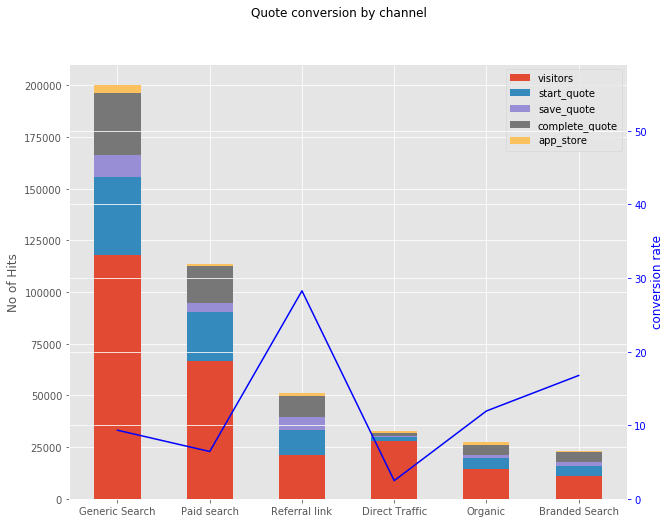

In [22]:
fig_conv_by_channel

## Channel contributions to app store visits and saved quotes over time

In [23]:
df = pd.read_csv('../data/raw/ga.csv', header=0, parse_dates=['date'], date_parser=utils.parse_csv_date, index_col='date')

In [24]:
# extract only data for 'app_store' or 'save_quote' metrics.
app_store_save_quote_data = df[(df['metric'] == 'app_store') | (df['metric'] == 'save_quote')]

# extract unique categories (channels) for data sub set.
categories = app_store_save_quote_data.groupby('metric')

category_metric_summary_data = list()

for key, values in categories:

    # group categories by weeks and then sum the metric counts.
    agg = values.groupby([pd.Grouper(freq='W'), 'category']).sum()
    
    # re-shape the data to use 'date' as index, and 'category' as columns.
    p = agg.reset_index().pivot('date', 'category', 'value')
    
    category_metric_summary_data.append(p)

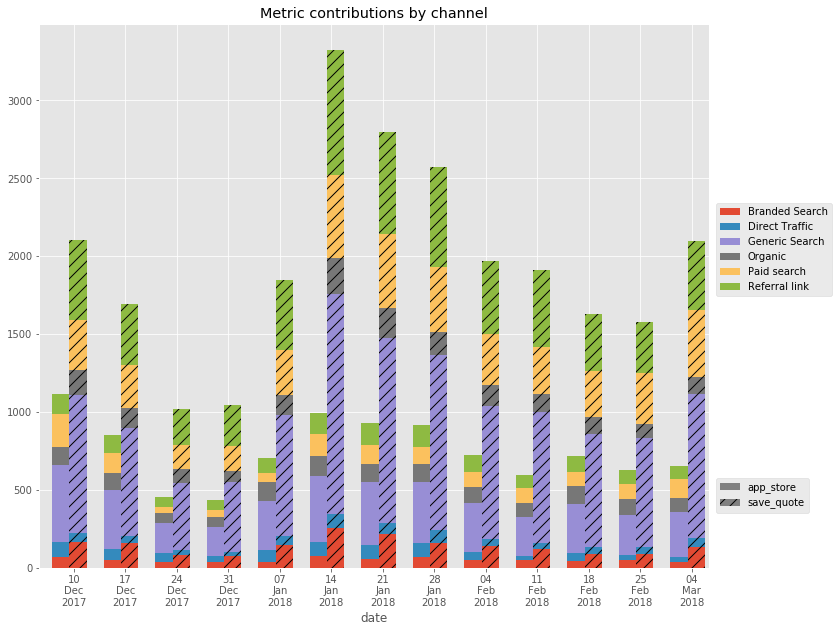

In [25]:
utils.plot_clustered_stacked(category_metric_summary_data, ["app_store", "save_quote"], H='//', xfmt=utils.x_date_format, title='Metric contributions by channel');

## Conclusion

* **Referral link** is the most 'critical' channel with respect to quote conversion (28% between Dec 2017 and Feb 2018). **Potential for further investigation to highlight contribution between £25 voucher offer factor vs. customer trust factor**.<br /><br />

* **Generic Search** is the route through which the largest proportion of website traffic arrives compared to other channels (45% share of all traffic between Dec 2017 and Feb 2018).<br /><br />

* Across all channels, contributions to App Store visits are low. Perhaps monitoring traffic directly via app stores would provide more useful metrics in this case.<br /><br />

## Conclusion

* **Loss of 62%** between visitors to site, and those who **begin a quote** between Dec 2017 and Feb 2018.<br /><br />

* **Loss of 73.7%** between visitors to site, and those who **complete a quote** between Dec 2017 and Feb 2018.<br /><br />

* Increase in quote conversion and visitor numbers observed immediately after Christmas period. Potential for additional marketing and/or special offers as people look to cut costs over Winter period.